In [3]:
	
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats

SEED = 12345
rng = np.random.default_rng(SEED)

def random_environment_sphere(rng=rng):  # returns a random normalized Bloch vector
    z = rng.uniform(-1, 1)
    phi = rng.uniform(-np.pi, np.pi)
    rxy = np.sqrt(1 - z**2)
    x = rxy * np.cos(phi)
    y = rxy * np.sin(phi)
    return np.array([x, y, z], dtype=float)

def classical_reward_PSMAQB(env, action):  # returns random outcome -1, +1 sampled via Born rule
    p1 = 0.5 + 0.5 * float(env @ action)  # prob of +1
    qreward = 1.0 if rng.random() < p1 else 0.0
    return 2.0 * qreward - 1.0

def weighted_distance(x, y, A):  # (x-y)^T A (x-y)
    difxy = x - y
    return float(difxy @ (A @ difxy))

def mom_lse(k, lse_list, vt_inverse): #return the mom of lse given design matrix v_t

    if k == 1:
        return lse_list[0]

    y = np.zeros(k, dtype=float)
    for j in range(k):
        dist_j = np.empty(k - 1, dtype=float)
        idx = 0
        for i in range(k):
            if i == j:
                continue
            dist_j[idx] = weighted_distance(lse_list[i], lse_list[j], vt_inverse)
            idx += 1
        y[j] = np.median(dist_j)

    mom_index = int(np.argmin(y))
    return lse_list[mom_index]

def action_selection(mom_normalized, min_eigvt, eigenvalues, eigenvectors):

    # Sort eigenvalues descending (max first)
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:, sorted_index]

    # Eigenvectors excluding maximal eigenvalue direction (take the remaining two)
    eigenvectors_except_max = eigenvectors[:, 1:].T  # shape (2,3)

    displacement_mom = 1.0 / np.sqrt(min_eigvt)

    a0 = mom_normalized + displacement_mom * eigenvectors_except_max[0]
    a1 = mom_normalized - displacement_mom * eigenvectors_except_max[0]
    a2 = mom_normalized + displacement_mom * eigenvectors_except_max[1]
    a3 = mom_normalized - displacement_mom * eigenvectors_except_max[1]

    actions = np.vstack([a0, a1, a2, a3])
    actions /= np.linalg.norm(actions, axis=1, keepdims=True)
    return actions

def depolarize_bloch(r, epsilon): #depolarized the unit bloch vector

    return (1.0 - epsilon) * r

import numpy as np

def qrelent_bloch(r, s, *, base=np.e, tol=1e-12):
    """
    Quantum relative entropy D( rho(r) || sigma(s) ) for qubit states given by Bloch vectors,
    assuming sigma(s) is full rank (i.e., ||s|| < 1).

    Returns nats by default; set base=2 for bits.
    """
    r = np.asarray(r, dtype=float).reshape(3,)
    s = np.asarray(s, dtype=float).reshape(3,)

    a = float(np.linalg.norm(r)) #purity of r
    b = float(np.linalg.norm(s)) #purity of b

    if a > 1 + 1e-9 or b > 1 + 1e-9:
        raise ValueError("Require ||r||, ||s|| <= 1 (up to numerical tolerance).")
    if b >= 1 - 1e-12:
        raise ValueError("Second argument must be full rank: require ||s|| < 1.")

    # Tr[rho log rho] = sum mu log mu, with 0 log 0 := 0
    mu_p = (1.0 + a) / 2.0
    mu_m = (1.0 - a) / 2.0
    tr_rho_log_rho = 0.0
    if mu_p > 0:
        tr_rho_log_rho += mu_p * np.log(mu_p)
    if mu_m > 0:
        tr_rho_log_rho += mu_m * np.log(mu_m)

    # Tr[rho log sigma]
        # --- Compute Tr[ rho(r) log sigma(s) ] ---
    #
    # Write sigma(s) in its spectral decomposition:
    #   sigma = λ_+ Π_+ + λ_- Π_-,
    #   Π_± = (I ± ŝ · σ)/2,   ŝ = s / ||s||,
    #   λ_± = (1 ± ||s||)/2.
    #
    # Then
    #   log sigma = (log λ_+) Π_+ + (log λ_-) Π_-.
    #
    # Hence
    #   Tr[ rho log sigma ]
    #     = (log λ_+) Tr[ rho Π_+ ] + (log λ_-) Tr[ rho Π_- ].
    #
    # For rho(r) = (I + r · σ)/2 one has
    #   Tr[ rho Π_± ] = (1 ± r · ŝ)/2.
    if b < tol:
        tr_rho_log_sigma = np.log(0.5)  # sigma = I/2
    else:
        shat = s / b
        c = float(np.dot(r, shat))  # = r · ŝ , 
        lam_p = (1.0 + b) / 2.0
        lam_m = (1.0 - b) / 2.0
        tr_rho_log_sigma = 0.5 * (1.0 + c) * np.log(lam_p) + 0.5 * (1.0 - c) * np.log(lam_m)

    D = tr_rho_log_rho - tr_rho_log_sigma

    if base != np.e:
        D /= np.log(base)

    # numerical guard
    if D < 0 and D > -1e-14:
        D = 0.0

    return float(D)
    
    

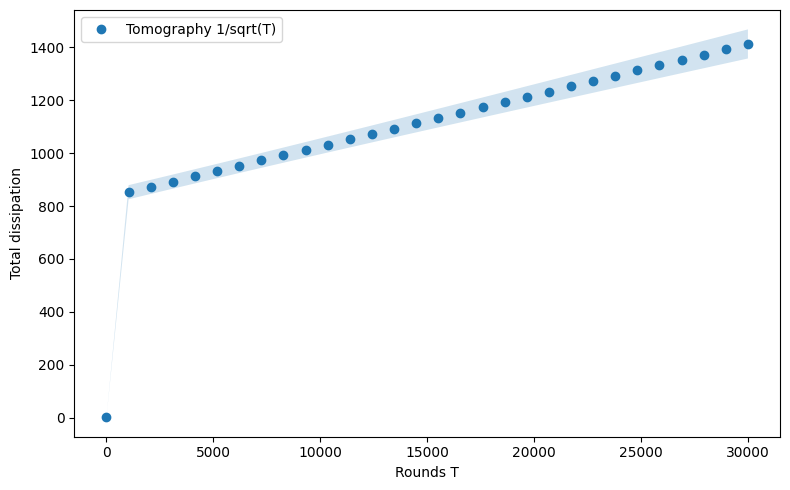

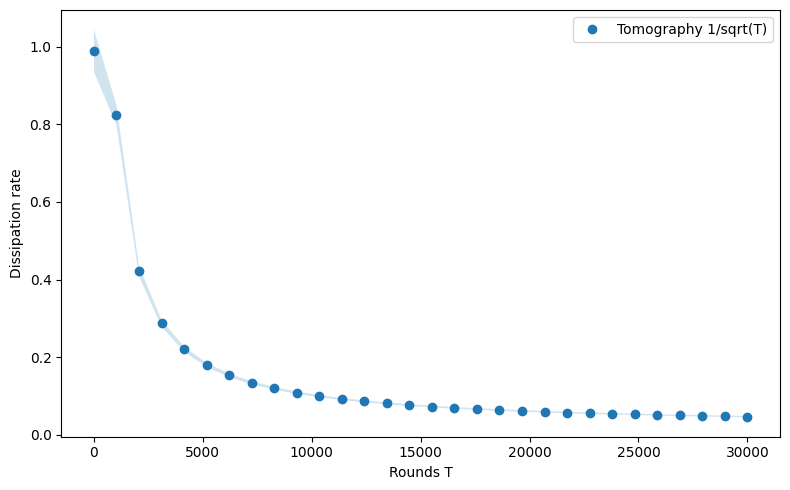

In [4]:
# --- Tomography benchmark (fixed-length trajectories): fraction 1/sqrt(T_total) ---



# Config
T_total_sqrt = 30000
n_traj_sqrt = 300

# Number of x-axis points to keep for plotting/comparison with other benchmarks
n_plot_points_sqrt = 30

# Tomography budget (single budget for the full trajectory)
m_rule_sqrt_traj = lambda T: max(3, int(round(5 * np.sqrt(T))))

eps_explore_sqrt_traj = 0.33
eps_commit_sqrt_traj = 1e-6
eps_commit_fn_sqrt_traj = None  # or lambda t, T, m: 1.0 / (t + 3.0)

axes_sqrt_traj = np.eye(3, dtype=float)

def _tomography_plan_sqrt_traj(m):
    base = m // 3
    rem = m % 3
    plan = np.repeat(np.arange(3), base)
    if rem > 0:
        extras = rng.choice(3, size=rem, replace=True)
        plan = np.concatenate([plan, extras])
    rng.shuffle(plan)
    return plan

def _estimate_bloch_sqrt_traj(sums, counts):
    rhat = np.zeros(3, dtype=float)
    for i in range(3):
        if counts[i] > 0:
            rhat[i] = sums[i] / counts[i]
    n = np.linalg.norm(rhat)
    if n > 1.0:
        rhat = rhat / n  # clip norm to 1
    return rhat

# Sample points (same count as other benchmarks if you want)
sample_idx_sqrt = np.linspace(0, T_total_sqrt - 1, n_plot_points_sqrt).round().astype(int)
sample_idx_sqrt = np.unique(sample_idx_sqrt)
sample_rounds_sqrt = sample_idx_sqrt + 1
n_samples_sqrt = len(sample_idx_sqrt)

# Storage: only sampled points
dissipation_samples_sqrt = np.zeros((n_traj_sqrt, n_samples_sqrt), dtype=float)
rate_samples_sqrt = np.zeros((n_traj_sqrt, n_samples_sqrt), dtype=float)

m_sqrt_traj = int(m_rule_sqrt_traj(T_total_sqrt))
m_sqrt_traj = max(0, min(m_sqrt_traj, T_total_sqrt))

for tr in range(n_traj_sqrt):
    env = random_environment_sphere()

    sums = np.zeros(3, dtype=float)
    counts = np.zeros(3, dtype=int)
    diss = 0.0
    s_ptr = 0

    # Tomography phase
    plan = _tomography_plan_sqrt_traj(m_sqrt_traj)
    for t in range(m_sqrt_traj):
        idx = plan[t]
        a = axes_sqrt_traj[idx]

        r = classical_reward_PSMAQB(env, a)
        sums[idx] += r
        counts[idx] += 1
        diss += qrelent_bloch(env, depolarize_bloch(a, eps_explore_sqrt_traj))

        while s_ptr < n_samples_sqrt and sample_idx_sqrt[s_ptr] == t:
            dissipation_samples_sqrt[tr, s_ptr] = diss
            rate_samples_sqrt[tr, s_ptr] = diss / float(t + 1)
            s_ptr += 1

    # Commit phase
    commit_action_sqrt = _estimate_bloch_sqrt_traj(sums, counts)

    for t in range(m_sqrt_traj, T_total_sqrt):
        _ = classical_reward_PSMAQB(env, commit_action_sqrt)

        if eps_commit_fn_sqrt_traj is None:
            eps = eps_commit_sqrt_traj
        else:
            eps = float(eps_commit_fn_sqrt_traj(t - m_sqrt_traj, T_total_sqrt, m_sqrt_traj))

        diss += qrelent_bloch(env, depolarize_bloch(commit_action_sqrt, eps))

        while s_ptr < n_samples_sqrt and sample_idx_sqrt[s_ptr] == t:
            dissipation_samples_sqrt[tr, s_ptr] = diss
            rate_samples_sqrt[tr, s_ptr] = diss / float(t + 1)
            s_ptr += 1

# Averages + CI over trajectories
mean_sqrt_traj = dissipation_samples_sqrt.mean(axis=0)
std_sqrt_traj = dissipation_samples_sqrt.std(axis=0, ddof=1)
ci95_sqrt_traj = 1.96 * std_sqrt_traj / np.sqrt(n_traj_sqrt)

rate_mean_sqrt_traj = rate_samples_sqrt.mean(axis=0)
rate_std_sqrt_traj = rate_samples_sqrt.std(axis=0, ddof=1)
rate_ci95_sqrt_traj = 1.96 * rate_std_sqrt_traj / np.sqrt(n_traj_sqrt)

# Plot total dissipation
plt.figure(figsize=(8, 5))
plt.plot(sample_rounds_sqrt, mean_sqrt_traj, marker='o', linestyle='none', label="Tomography 1/sqrt(T)")
plt.fill_between(sample_rounds_sqrt, mean_sqrt_traj - ci95_sqrt_traj, mean_sqrt_traj + ci95_sqrt_traj, alpha=0.2)
plt.xlabel("Rounds T")
plt.ylabel("Total dissipation")
plt.legend()
plt.tight_layout()

# Plot dissipation rate
plt.figure(figsize=(8, 5))
plt.plot(sample_rounds_sqrt, rate_mean_sqrt_traj, marker='o', linestyle='none', label="Tomography 1/sqrt(T)")
plt.fill_between(sample_rounds_sqrt, rate_mean_sqrt_traj - rate_ci95_sqrt_traj, rate_mean_sqrt_traj + rate_ci95_sqrt_traj, alpha=0.2)
plt.xlabel("Rounds T")
plt.ylabel("Dissipation rate")
plt.legend()
plt.tight_layout()


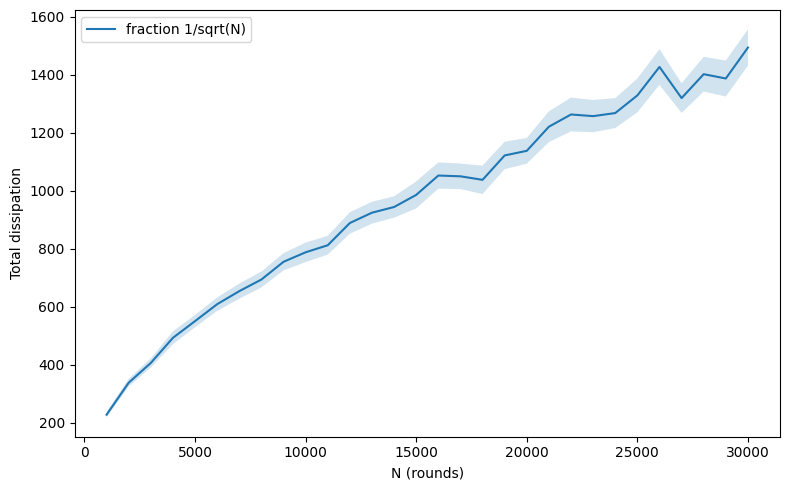

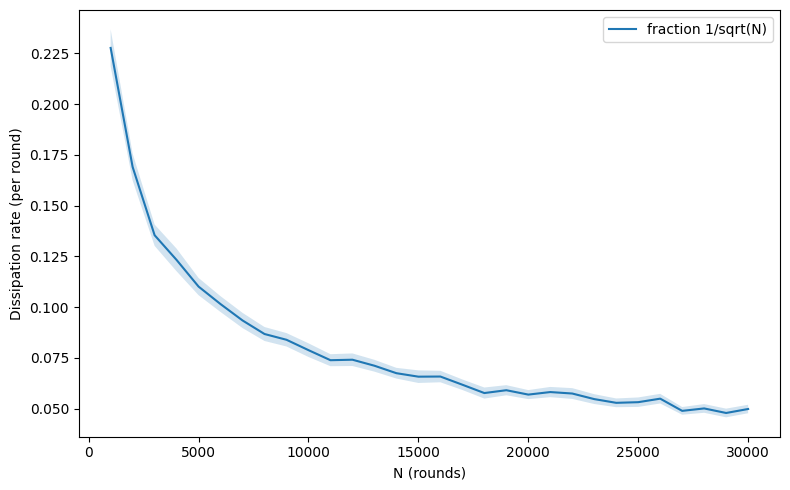

In [5]:
# --- Independent Tomography benchmark: fraction 1/sqrt(N)  =>  m = sqrt(N) ---

# Config
N_values_sqrt = np.arange(1000, 30001, 1000)
expectation_sqrt = 300

m_rule_sqrt = lambda N: max(3, int(round(5*np.sqrt(N))))  # N^(1/2)

eps_explore_sqrt = 0.33
eps_commit_sqrt = 1e-6
eps_commit_fn_sqrt = None  # or lambda t, N, m: 1.0 / (t + 3.0)

# Storage
dissipation_runs_sqrt = np.zeros((expectation_sqrt, len(N_values_sqrt)), dtype=float)
dissipation_rate_runs_sqrt = np.zeros((expectation_sqrt, len(N_values_sqrt)), dtype=float)

axes_sqrt = np.eye(3, dtype=float)

def _tomography_plan_sqrt(m):
    base = m // 3
    rem = m % 3
    plan = np.repeat(np.arange(3), base)
    if rem > 0:
        extras = rng.choice(3, size=rem, replace=True)
        plan = np.concatenate([plan, extras])
    rng.shuffle(plan)
    return plan

def _estimate_bloch_sqrt(sums, counts):
    rhat = np.zeros(3, dtype=float)
    for i in range(3):
        if counts[i] > 0:
            rhat[i] = sums[i] / counts[i]
    n = np.linalg.norm(rhat)
    if n > 1.0:
        rhat = rhat / n  # clip to norm 1
    return rhat

# Loop over N values
for iN, N in enumerate(N_values_sqrt):
    m = int(m_rule_sqrt(N))
    m = max(0, min(m, N))

    for expect in range(expectation_sqrt):
        env = random_environment_sphere()

        sums = np.zeros(3, dtype=float)
        counts = np.zeros(3, dtype=int)

        diss = 0.0

        # --- Tomography rounds ---
        plan = _tomography_plan_sqrt(m)
        for idx in plan:
            a = axes_sqrt[idx]
            r = classical_reward_PSMAQB(env, a)
            sums[idx] += r
            counts[idx] += 1
            diss += qrelent_bloch(env, depolarize_bloch(a, eps_explore_sqrt))

        # --- Estimate and commit ---
        commit_action = _estimate_bloch_sqrt(sums, counts)

        for t in range(N - m):
            _ = classical_reward_PSMAQB(env, commit_action)
            eps = eps_commit_sqrt if eps_commit_fn_sqrt is None else float(eps_commit_fn_sqrt(t, N, m))
            diss += qrelent_bloch(env, depolarize_bloch(commit_action, eps))

        dissipation_runs_sqrt[expect, iN] = diss
        dissipation_rate_runs_sqrt[expect, iN] = diss / float(N)

# Averages + CI
mean_sqrt = dissipation_runs_sqrt.mean(axis=0)
std_sqrt = dissipation_runs_sqrt.std(axis=0, ddof=1)
ci95_sqrt = 1.96 * std_sqrt / np.sqrt(expectation_sqrt)

rate_mean_sqrt = dissipation_rate_runs_sqrt.mean(axis=0)
rate_std_sqrt = dissipation_rate_runs_sqrt.std(axis=0, ddof=1)
rate_ci95_sqrt = 1.96 * rate_std_sqrt / np.sqrt(expectation_sqrt)
# Plot total dissipation
plt.figure(figsize=(8, 5))
plt.plot(N_values_sqrt, mean_sqrt, label="fraction 1/sqrt(N)")
plt.fill_between(N_values_sqrt, mean_sqrt - ci95_sqrt, mean_sqrt + ci95_sqrt, alpha=0.2)
plt.xlabel("N (rounds)")
plt.ylabel("Total dissipation")
plt.legend()
plt.tight_layout()

# Plot dissipation rate
plt.figure(figsize=(8, 5))
plt.plot(N_values_sqrt, rate_mean_sqrt, label="fraction 1/sqrt(N)")
plt.fill_between(N_values_sqrt, rate_mean_sqrt - rate_ci95_sqrt, rate_mean_sqrt + rate_ci95_sqrt, alpha=0.2)
plt.xlabel("N (rounds)")
plt.ylabel("Dissipation rate (per round)")
plt.legend()
plt.tight_layout()


In [6]:
# PSMAQB with median of means for qubits LinUCB-VNN

start_time = time.time()

d_cl = 3              # classical real dimension, 3 for qubits
beta = 2.0
exploration = 10 # exploration blocks (each block measures x,y,z once)
T_tilde = 1500
expectation = 50
k = 5             # number of subsamples for median of means


# Total number of *rounds* = number of reward draws
# exploration: d_cl * exploration
# main loop: 2*(d_cl-1)*k*T_tilde
n_rounds = d_cl * exploration + 2*(d_cl - 1) * k * T_tilde

# Dissipation accumulator
dissipation_list = np.zeros(n_rounds, dtype=float)
# Dissipation rate accumulator (cumulative dissipation / rounds)
dissipation_rate_list = np.zeros(n_rounds, dtype=float)

# For plotting
plot_rounds = 1000
n_points = n_rounds // plot_rounds
dissipation_runs = np.zeros((expectation, n_points), dtype=float)
dissipation_rate_runs = np.zeros((expectation, n_points), dtype=float)

for expect in range(expectation):

    env = random_environment_sphere()
    mom_lse_normalized = random_environment_sphere()  # initial estimator (unit)
    wlse_k = np.zeros((k, 3), dtype=float)

    dissipation = 0.0
    index_dissipation = 0

    # --- Exploration part ---
    expl_wlse = np.zeros(3, dtype=float)
    a1 = np.array([1.0, 0.0, 0.0])
    a2 = np.array([0.0, 1.0, 0.0])
    a3 = np.array([0.0, 0.0, 1.0])

    for _ in range(exploration):
        for a in (a1, a2, a3):
            r = classical_reward_PSMAQB(env, a)
            expl_wlse += r * a

            dissipation += qrelent_bloch(env, depolarize_bloch(a,0.33)) 
            dissipation_list[index_dissipation] += dissipation
                   # rate at round (index_dissipation+1)
            dissipation_rate_list[index_dissipation] += dissipation / (index_dissipation + 1)
            index_dissipation += 1


            if (index_dissipation % plot_rounds) == 0:
                j = index_dissipation // plot_rounds - 1
                dissipation_runs[expect, j] = dissipation

    # Design matrix after exploration
    vt = exploration * np.eye(3, dtype=float)

    # Initialize all estimators with exploration contribution
    wlse_k[:] = expl_wlse

    # --- Main loop ---
    for t in range(T_tilde):

        eigenvalues, eigenvectors = np.linalg.eig(vt)
        min_eigvt = float(np.min(eigenvalues))
        max_eigvt = float(np.max(eigenvalues))

        vt_inverse = np.linalg.inv(vt)

        weight = 2.0 * np.sqrt(max_eigvt) / beta

        actions = action_selection(
            mom_lse_normalized, min_eigvt, eigenvalues, eigenvectors
        )

        for at in actions:

            for subsample in range(k):
                reward_cl = classical_reward_PSMAQB(env, at)
                wlse_k[subsample] += weight * reward_cl * at

                dissipation += qrelent_bloch(env, depolarize_bloch(at,1/(t+3))) 
                dissipation_list[index_dissipation] += dissipation
                dissipation_rate_list[index_dissipation] += dissipation / (index_dissipation + 1)
                index_dissipation += 1

                if (index_dissipation % plot_rounds) == 0:
                    j = index_dissipation // plot_rounds - 1
                    dissipation_runs[expect, j] = dissipation
                    dissipation_rate_runs[expect, j] = dissipation / index_dissipation


            vt += weight * np.outer(at, at)

        # Update MoM estimator
        mom_lse_normalized = mom_lse(k, wlse_k, vt_inverse)
        mom_lse_normalized = vt_inverse @ mom_lse_normalized
        mom_lse_normalized /= np.linalg.norm(mom_lse_normalized)

# Average over expectation
dissipation_list /= expectation
dissipation_rate_list /= expectation

# Standard error / 95% CI for plotting
mean = dissipation_runs.mean(axis=0)
std = dissipation_runs.std(axis=0, ddof=1)
ci95 = 1.96 * std / np.sqrt(expectation)
# Standard error / 95% CI for plotting (RATE)
rate_mean = dissipation_rate_runs.mean(axis=0)
rate_std = dissipation_rate_runs.std(axis=0, ddof=1)
rate_ci95 = 1.96 * rate_std / np.sqrt(expectation)

end_time = time.time()
print(end_time - start_time)


13.520982027053833


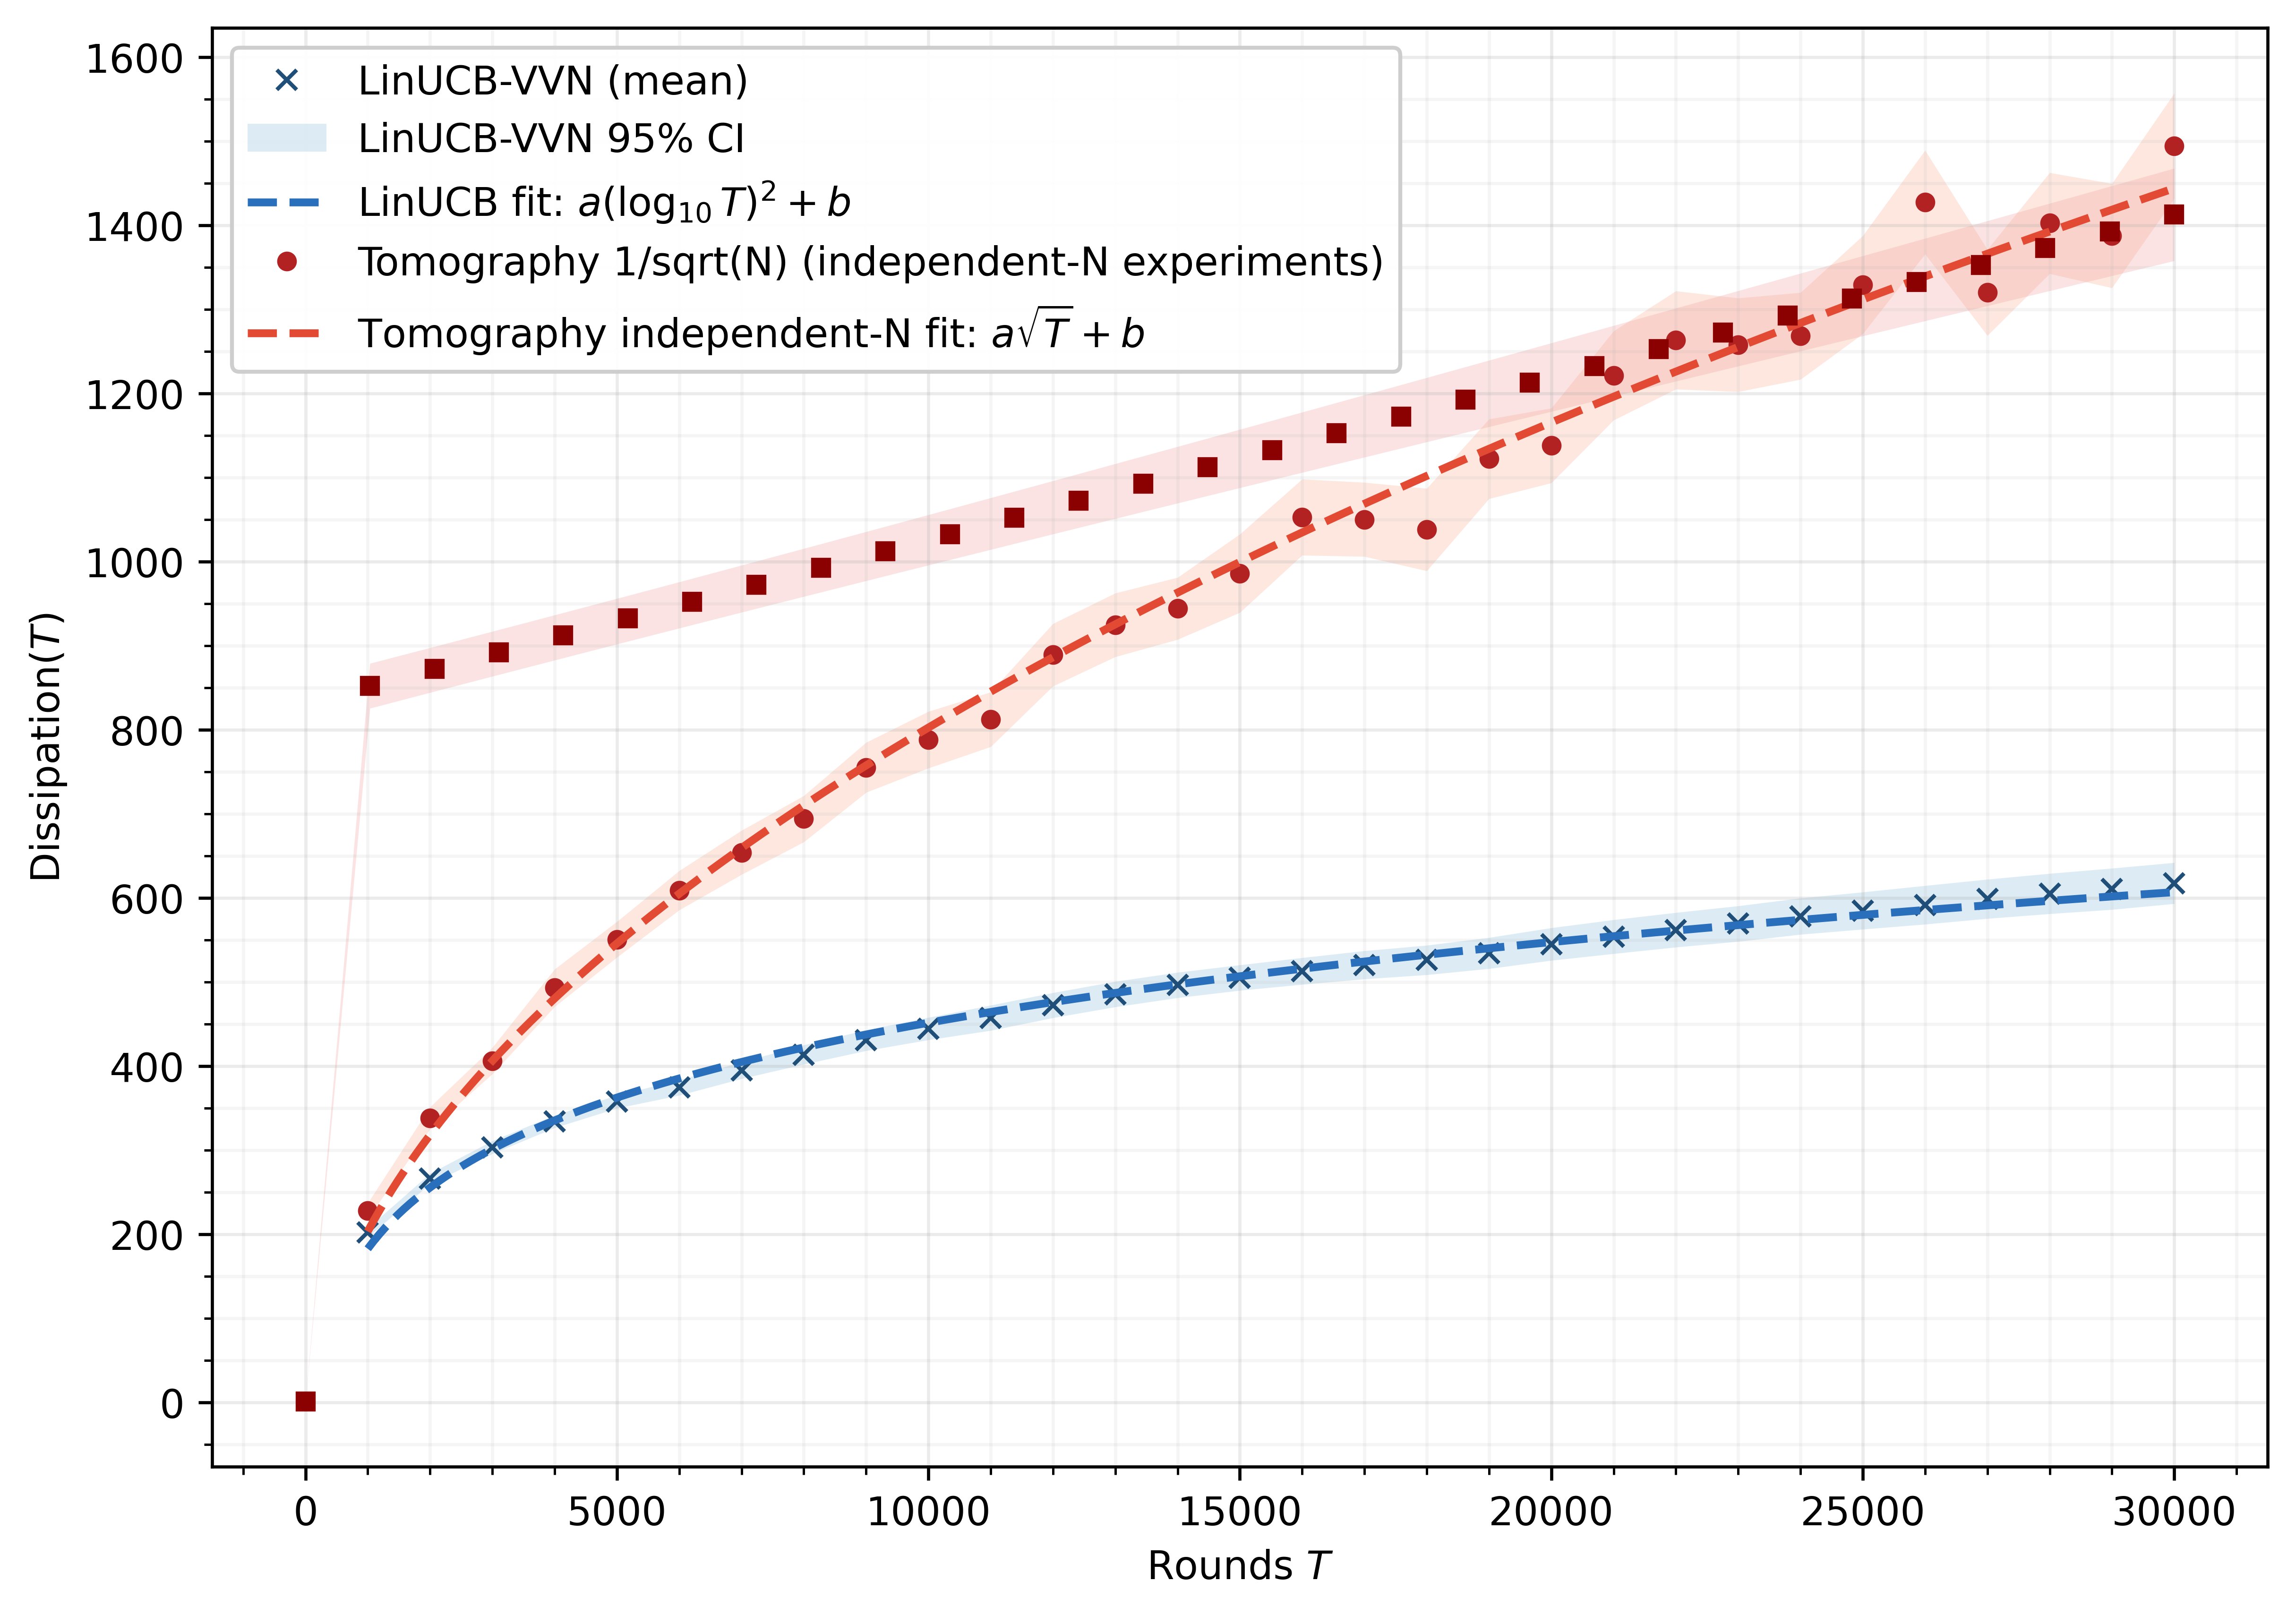

In [11]:
# Dissipation plot: keep fits for main + tomography independent-N, no fit for single-trajectory tomography



rounds_dissipation_less = plot_rounds * (np.arange(len(mean)) + 1)

# --- Fit: main method ~ a (log10 T)^2 + b ---
x_feat_main = (np.log10(rounds_dissipation_less))**2
fit_main = stats.linregress(x_feat_main, mean)
m_main, b_main = fit_main.slope, fit_main.intercept

x_reg_main = np.linspace(rounds_dissipation_less[0], rounds_dissipation_less[-1], 300)
y_fit_main = m_main * (np.log10(x_reg_main)**2) + b_main

# --- Fit: tomography independent-N ~ a*sqrt(T) + b ---
x_feat_tomo_ind = np.sqrt(N_values_sqrt)
fit_tomo_ind = stats.linregress(x_feat_tomo_ind, mean_sqrt)
m_tomo_ind, b_tomo_ind = fit_tomo_ind.slope, fit_tomo_ind.intercept

x_reg_tomo_ind = np.linspace(N_values_sqrt[0], N_values_sqrt[-1], 300)
y_fit_tomo_ind = m_tomo_ind * np.sqrt(x_reg_tomo_ind) + b_tomo_ind

# --- Colors (consistent palette) ---
blue_main = "#1f4e79"
blue_fit  = "#2a6fbb"
blue_ci   = "#9ecae1"

red_ind_main = "#b22222"
red_ind_fit  = "#e34a33"
red_ind_ci   = "#fcbba1"

red_traj_main = "#8b0000"
red_traj_ci   = "#f4a3a3"

plt.figure(figsize=(8.2, 5.8), dpi=600)

# Main method: data + CI + fit
plt.plot(
    rounds_dissipation_less,
    mean,
    marker='x',
    linestyle='none',
    markersize=5,
    color=blue_main,
    label="LinUCB-VVN (mean)"
)
plt.fill_between(
    rounds_dissipation_less,
    mean - ci95,
    mean + ci95,
    color=blue_ci,
    alpha=0.35,
    linewidth=0,
    label="LinUCB-VVN 95% CI"
)
plt.plot(
    x_reg_main,
    y_fit_main,
    linestyle='--',
    linewidth=2.0,
    color=blue_fit,
    label=r"LinUCB fit: $a(\log_{10} T)^2 + b$"
)

# Tomography independent-N: data + CI + fit
plt.plot(
    N_values_sqrt,
    mean_sqrt,
    marker='o',
    linestyle='none',
    markersize=4,
    color=red_ind_main,
    label="Tomography 1/sqrt(N) (independent-N experiments)"
)
plt.fill_between(
    N_values_sqrt,
    mean_sqrt - ci95_sqrt,
    mean_sqrt + ci95_sqrt,
    color=red_ind_ci,
    alpha=0.35,
    linewidth=0
)
plt.plot(
    x_reg_tomo_ind,
    y_fit_tomo_ind,
    linestyle='--',
    linewidth=2.0,
    color=red_ind_fit,
    label=r"Tomography independent-N fit: $a\sqrt{T} + b$"
)

# Tomography single-trajectory: data + CI (no fit)
plt.plot(
    sample_rounds_sqrt,
    mean_sqrt_traj,
    marker='s',
    linestyle='none',
    markersize=4,
    label = r"Tomography single-trajectory",
    color=red_traj_main
)
plt.fill_between(
    sample_rounds_sqrt,
    mean_sqrt_traj - ci95_sqrt_traj,
    mean_sqrt_traj + ci95_sqrt_traj,
    color=red_traj_ci,
    alpha=0.30,
    linewidth=0
)

plt.xlabel(r'Rounds $T$')
plt.ylabel(r'$\mathrm{Dissipation}(T)$')
plt.grid(True, which="major", alpha=0.25)
plt.grid(True, which="minor", alpha=0.12)
plt.minorticks_on()

plt.legend(frameon=True, framealpha=0.95)
plt.tight_layout()
plt.savefig("PSMAQB_dissipation_compare_with_fits.jpeg")
plt.show()



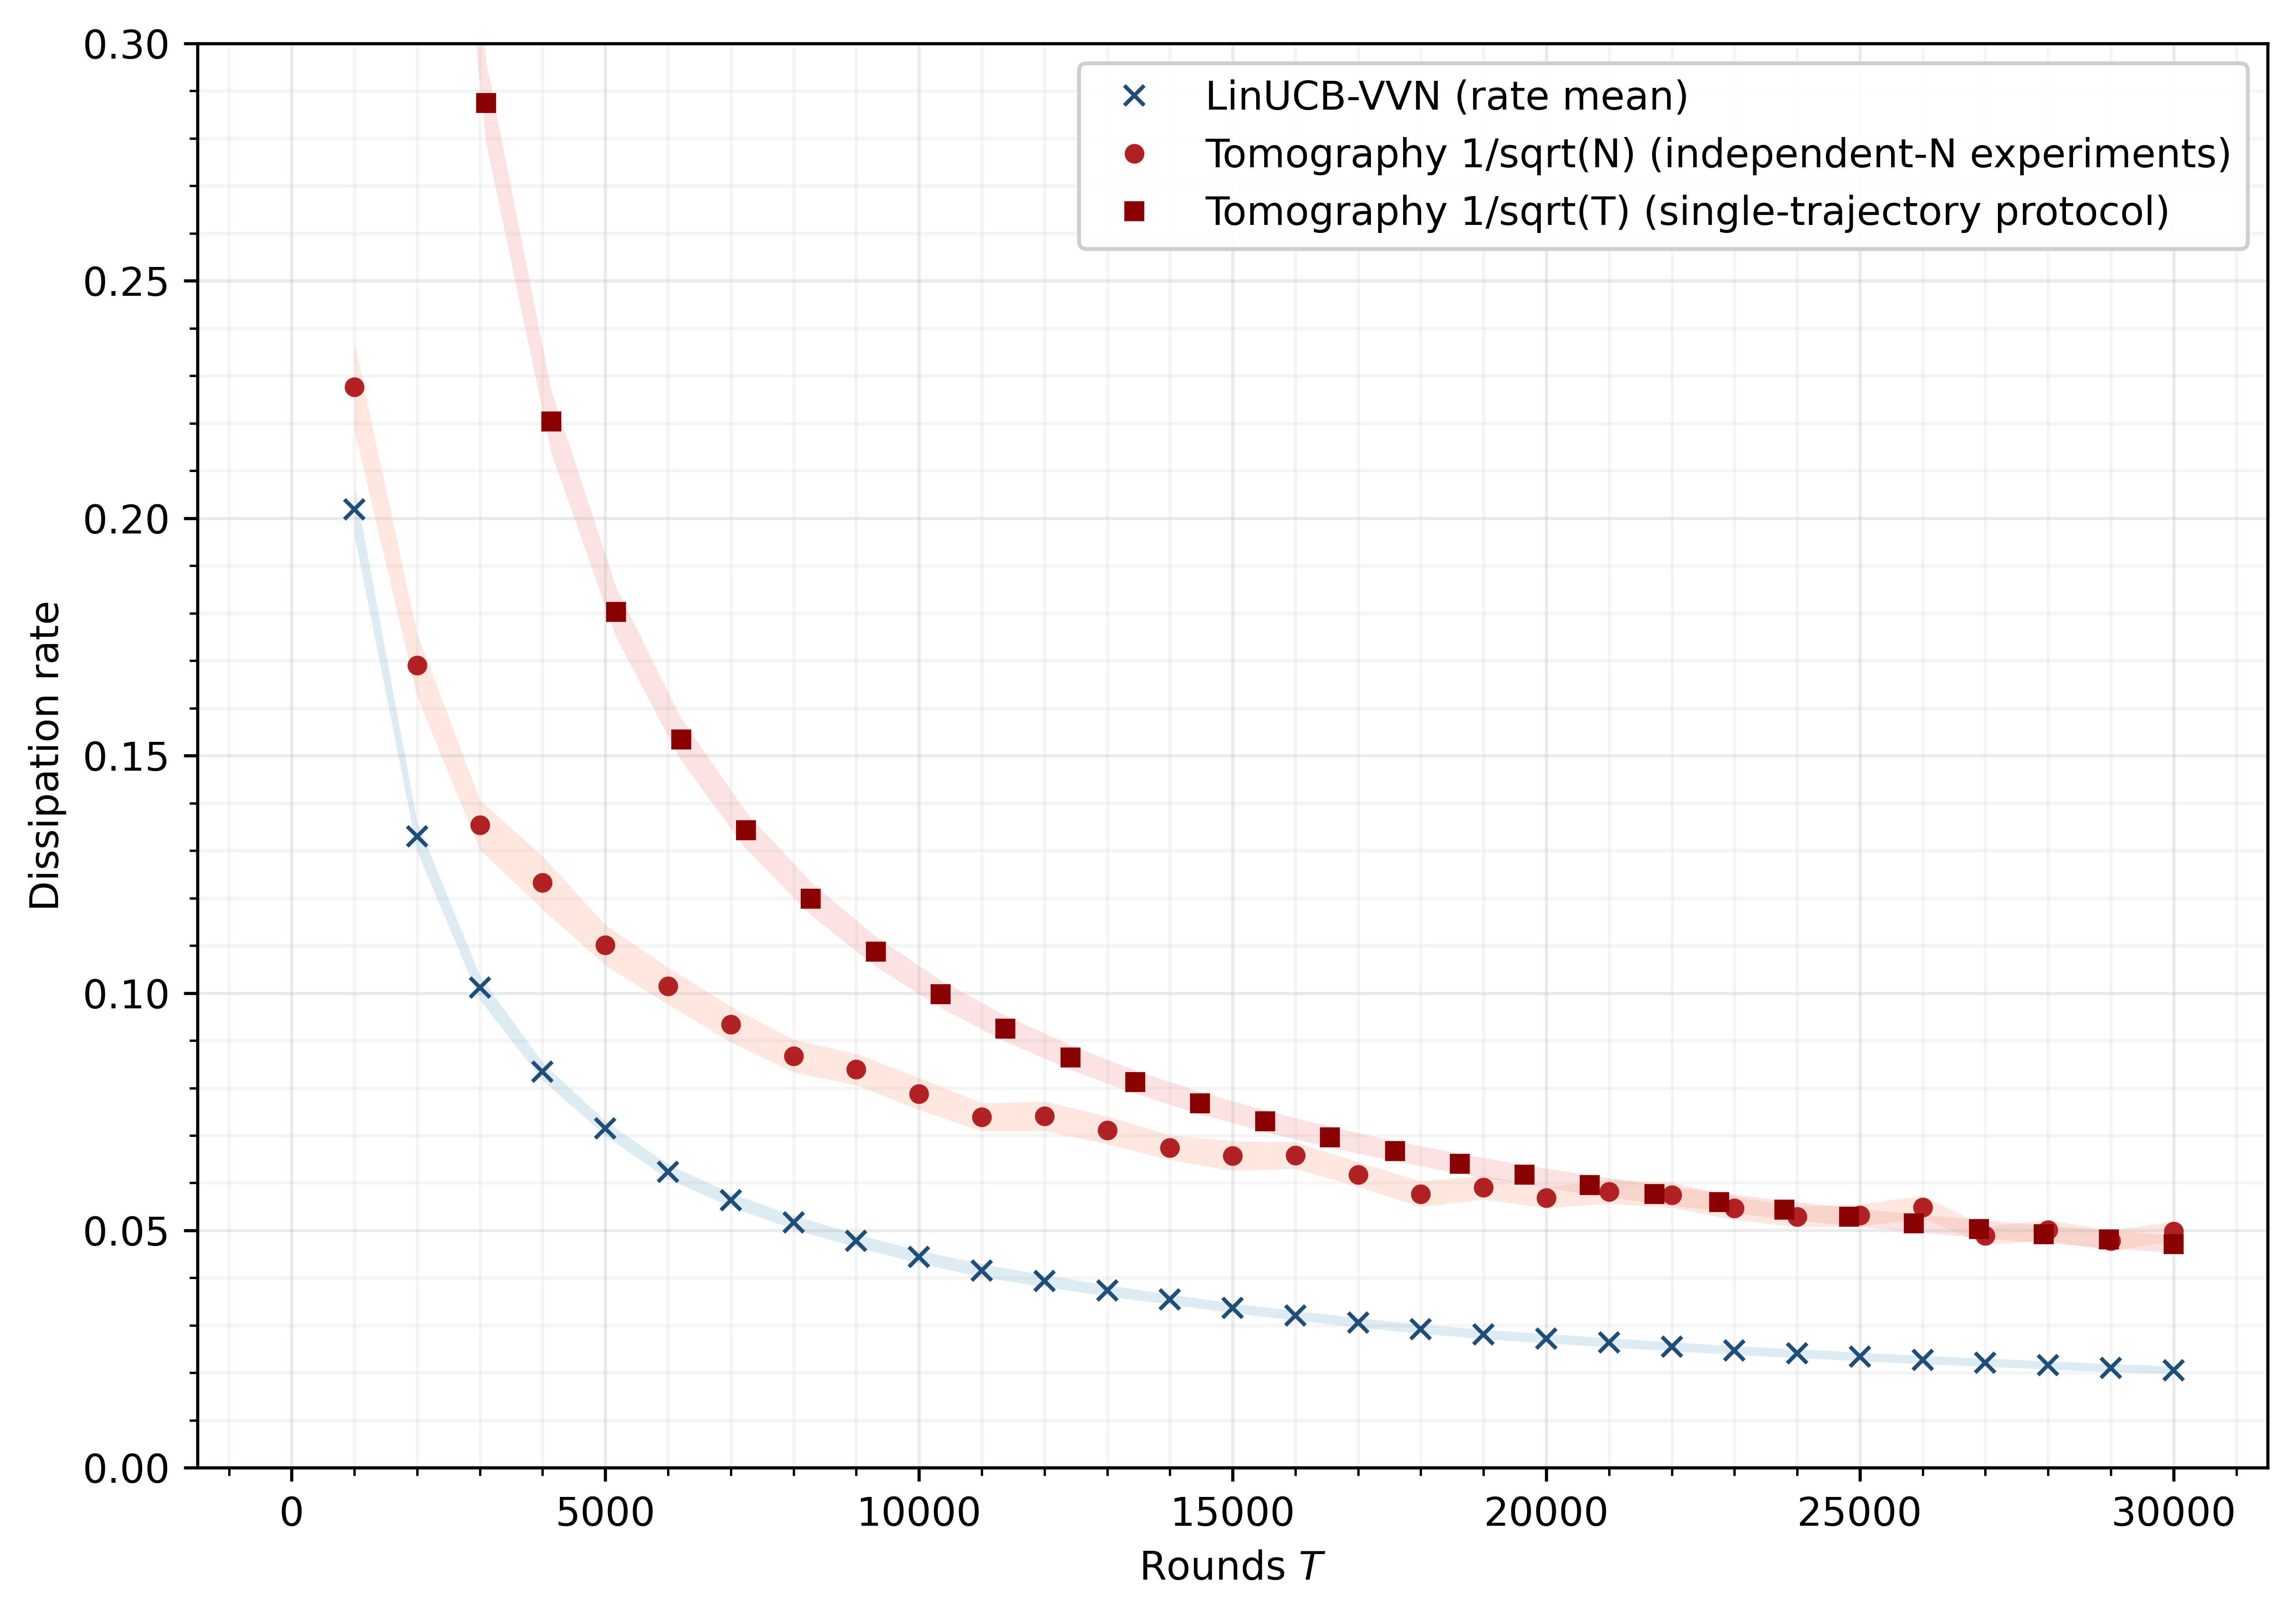

In [13]:
# Rate plot (no fits): main method + tomography independent-N + tomography single-trajectory



rounds_less = plot_rounds * (np.arange(len(rate_mean)) + 1)

# Color palette consistent with dissipation plot
blue_main = "#1f4e79"
blue_ci   = "#9ecae1"

red_ind_main = "#b22222"
red_ind_ci   = "#fcbba1"

red_traj_main = "#8b0000"
red_traj_ci   = "#f4a3a3"

plt.figure(figsize=(8.2, 5.8), dpi=600)

# Main method
plt.plot(
    rounds_less,
    rate_mean,
    marker='x',
    linestyle='none',
    markersize=5,
    color=blue_main,
    label="LinUCB-VVN (rate mean)"
)
plt.fill_between(
    rounds_less,
    rate_mean - rate_ci95,
    rate_mean + rate_ci95,
    color=blue_ci,
    alpha=0.35,
    linewidth=0
)

# Tomography: independent experiments per N
plt.plot(
    N_values_sqrt,
    rate_mean_sqrt,
    marker='o',
    linestyle='none',
    markersize=4,
    color=red_ind_main,
    label="Tomography 1/sqrt(N) (independent-N experiments)"
)
plt.fill_between(
    N_values_sqrt,
    rate_mean_sqrt - rate_ci95_sqrt,
    rate_mean_sqrt + rate_ci95_sqrt,
    color=red_ind_ci,
    alpha=0.35,
    linewidth=0
)

# Tomography: single fixed-length trajectories
plt.plot(
    sample_rounds_sqrt,
    rate_mean_sqrt_traj,
    marker='s',
    linestyle='none',
    markersize=4,
    color=red_traj_main,
    label="Tomography 1/sqrt(T) (single-trajectory protocol)"
)
plt.fill_between(
    sample_rounds_sqrt,
    rate_mean_sqrt_traj - rate_ci95_sqrt_traj,
    rate_mean_sqrt_traj + rate_ci95_sqrt_traj,
    color=red_traj_ci,
    alpha=0.30,
    linewidth=0
)

plt.xlabel(r'Rounds $T$')
plt.ylabel(r'Dissipation rate')

# Limit y-axis range
plt.ylim(0.0, 0.3)

plt.grid(True, which="major", alpha=0.25)
plt.grid(True, which="minor", alpha=0.12)
plt.minorticks_on()

plt.legend(frameon=True, framealpha=0.95)
plt.tight_layout()
plt.savefig("PSMAQB_dissipation_rate_compare_no_fit.jpeg")
plt.show()




